In [1]:
# Heat transfer example based on a Julia example
#
# see:
# https://docs.sciml.ai/MethodOfLines/stable/tutorials/heat/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyfvtool as pf

In [3]:
def T_analytic(x,t):
    return np.exp(-t)*np.cos(x)

In [4]:
# Parameters
L = 1.0 # domain length
alfa = 1.0 # heat diffusion
qs = 1000.0 # [W/m^2]
t_sim = L**2/(20*alfa) # [s]
time_steps = 50
dt = t_sim/time_steps # 
Nx = 20 # number of cells

In [5]:
m = pf.Grid1D(Nx, L)

In [6]:
# Boundary conditions
BC = pf.BoundaryConditions(m)
BC.left.a[:] = 0.0
BC.left.b[:] = 1.0
BC.right.a[:] = 0.0
BC.right.b[:] = 1.0

In [7]:
# Initial condition
T0 = np.cos(m.cellcenters.x) # cosine temperature profile, amplitude = 1.0 K
T_init = pf.CellVariable(m, T0, BC) # initial condition

In [8]:
# physical parameters
alfa_cell = pf.CellVariable(m, alfa, pf.BoundaryConditions(m))
alfa_face = pf.harmonicMean(alfa_cell)

In [9]:
M_diff = pf.diffusionTerm(alfa_face)

In [10]:
t=0
while t<t_sim:
    t +=dt
    [M_trans, RHS_trans] = pf.transientTerm(T_init, dt, 1.0)
    BC.left.c[:] = np.exp(-t)
    BC.right.c[:] = np.exp(-t)*np.cos(L)
    [M_bc, RHS_bc] = pf.boundaryConditionsTerm(BC)
    T_val = pf.solveMatrixPDE(m, M_bc+M_trans-M_diff, RHS_bc+RHS_trans)
    T_init.update_value(T_val)

In [11]:
x = m.facecenters.x
T_face = pf.linearMean(T_val)
T_num = T_face.xvalue
T_an = T_analytic(x, t_sim)

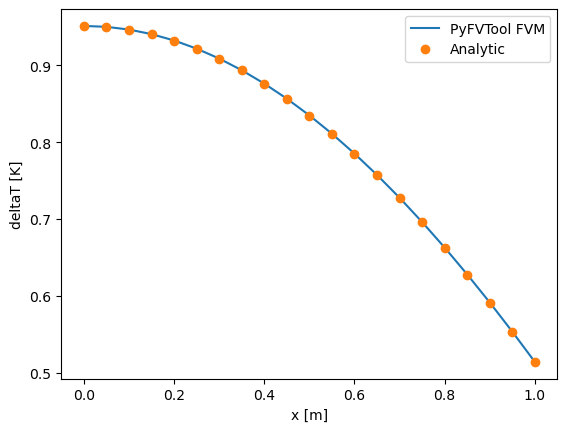

In [12]:
plt.figure(1)
plt.clf()
plt.plot(x, T_an, x, T_num, 'o')
plt.legend({'Analytic', 'PyFVTool FVM'})
plt.xlabel('x [m]')
plt.ylabel('deltaT [K]')
plt.show()

In [13]:
er = np.sum(np.abs(T_num-T_an)/T_an)/Nx
print(er)

0.00014085141590735798


In [14]:
assert er<0.0005